Курсовой проект для курса "Библиотеки Python для Data Science: Numpy, Matplotlib, Scikit-learn" часть 1. Садкова Е.

In [1]:
import numpy as np
import pandas as pd
import random
import scipy

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
matplotlib.rcParams.update({'font.size': 14})

In [4]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [5]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [6]:
TRAIN_DATASET_PATH = './archive/real-estate-price-prediction-moscow/train.csv'
TEST_DATASET_PATH = './archive/real-estate-price-prediction-moscow/test.csv'

Описание датасета

Id - идентификационный номер квартиры 
DistrictId - идентификационный номер района 
Rooms - количество комнат 
Square - площадь 
LifeSquare - жилая площадь 
KitchenSquare - площадь кухни 
Floor - этаж 
HouseFloor - количество этажей в доме 
HouseYear - год постройки дома 
Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности 
Social_1, Social_2, Social_3 - социальные показатели местности 
Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья 
Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров 
Price - цена квартиры

Обзор данных

In [7]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df = reduce_mem_usage(train_df)
train_df.head()

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.875000
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.546875
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.718750
3,2352,1,1.0,40.409908,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.000000
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.093750


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  int16   
 1   DistrictId     10000 non-null  int16   
 2   Rooms          10000 non-null  float32 
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  float32 
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  int8    
 17  Shops_1        10000 non-null  i

In [9]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df = reduce_mem_usage(test_df)
test_df.head()

Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.22 MB
Decreased by 70.3%


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094183,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493908,42.568134,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463676,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893826,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837055,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


In [10]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             5000 non-null   int16   
 1   DistrictId     5000 non-null   int16   
 2   Rooms          5000 non-null   float32 
 3   Square         5000 non-null   float32 
 4   LifeSquare     3959 non-null   float32 
 5   KitchenSquare  5000 non-null   float32 
 6   Floor          5000 non-null   int8    
 7   HouseFloor     5000 non-null   float32 
 8   HouseYear      5000 non-null   int16   
 9   Ecology_1      5000 non-null   float32 
 10  Ecology_2      5000 non-null   category
 11  Ecology_3      5000 non-null   category
 12  Social_1       5000 non-null   int8    
 13  Social_2       5000 non-null   int16   
 14  Social_3       5000 non-null   int16   
 15  Healthcare_1   2623 non-null   float32 
 16  Helthcare_2    5000 non-null   int8    
 17  Shops_1        5000 non-null   in

In [11]:
test_df['Id'] = test_df['Id'].astype(str)
test_df['DistrictId'] = test_df['DistrictId'].astype(str)

In [12]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

In [13]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.0000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315720,37.199665,6.273300,8.526700,12.6094,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.937500
std,0.839522,21.058716,86.241219,28.560839,5.241148,6.7762,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.519470,1.493601,4.806341,92872.273438
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.0000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,1.000000,41.774879,22.769833,1.000000,4.000000,9.0000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,2.000000,52.513309,32.781261,6.000000,7.000000,13.0000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,2.000000,65.900627,45.128803,9.000000,12.000000,17.0000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.0000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


In [14]:
test_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,1.910000,56.449512,36.158756,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657227,1.31940,4.242800
std,0.838586,19.092773,17.825274,9.950069,5.483228,6.789165,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.745605,1.47994,4.777365
min,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,1.000000,41.906230,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,2.000000,52.921339,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,2.000000,66.285130,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,17.000000,223.453690,303.071106,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


Целевая переменная

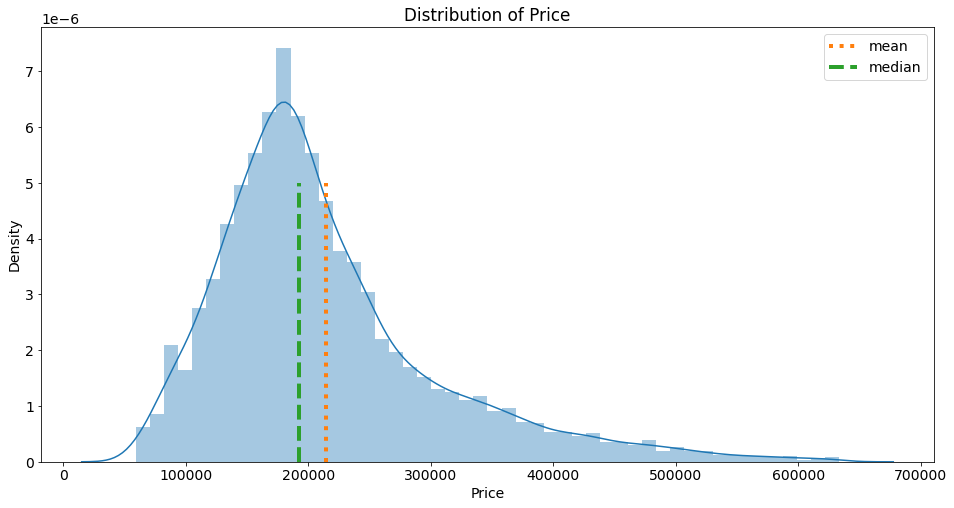

In [15]:
target_mean = round(train_df['Price'].mean(), 2)
target_median = train_df['Price'].median()

plt.figure(figsize = (16, 8))

sns.distplot(train_df['Price'], bins=50)

y = np.linspace(0, 0.000005, 10)
plt.plot([target_mean] * 10, y, label='mean', linestyle=':', linewidth=4)
plt.plot([target_median] * 10, y, label='median', linestyle='--', linewidth=4)

plt.title('Distribution of Price')
plt.legend()
plt.show()

Выбросы

Rooms

In [16]:
train_df['Rooms'].value_counts().sort_index()

0.0        8
1.0     3705
2.0     3880
3.0     2235
4.0      150
5.0       18
6.0        1
10.0       2
19.0       1
Name: Rooms, dtype: int64

In [17]:
train_df.loc[train_df['Rooms'].isin([0, 10, 19]), 'Rooms'] = train_df['Rooms'].median()

In [18]:
test_df['Rooms'].value_counts().sort_index()

0.0        2
1.0     1769
2.0     2030
3.0     1099
4.0       90
5.0        7
6.0        2
17.0       1
Name: Rooms, dtype: int64

In [19]:
test_df.loc[test_df['Rooms'].isin([0, 17]), 'Rooms'] = train_df['Rooms'].median()

Square, LifeSquare, KitchenSquare

In [20]:
condition = (train_df['Square'] > train_df['Square'].quantile(.975)) | (train_df['Square'] < train_df['Square'].quantile(.025))
train_df.loc[condition, 'Square'] = train_df['Square'].median()

In [21]:
condition = (train_df['LifeSquare'] > train_df['LifeSquare'].quantile(.975)) | (train_df['LifeSquare'] < train_df['LifeSquare'].quantile(.025))
train_df.loc[condition, 'LifeSquare'] = train_df['LifeSquare'].median()
train_df.loc[train_df['LifeSquare'] < 10, 'LifeSquare'] = 10

In [22]:
condition = (test_df['KitchenSquare'].isna()) \
             | (test_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.975))
        
test_df.loc[condition, 'KitchenSquare'] = train_df['KitchenSquare'].median()

test_df.loc[test_df['KitchenSquare'] < 3, 'KitchenSquare'] = np.random.randint(3, 12)

In [23]:
condition = (test_df['Square'] > train_df['Square'].quantile(.975)) | (test_df['Square'] < train_df['Square'].quantile(.025))
test_df.loc[condition, 'Square'] = train_df['Square'].median()

In [24]:
condition = (test_df['LifeSquare'] > train_df['LifeSquare'].quantile(.975)) | (test_df['LifeSquare'] < train_df['LifeSquare'].quantile(.025))
test_df.loc[condition, 'LifeSquare'] = train_df['LifeSquare'].median()
test_df.loc[train_df['LifeSquare'] < 10, 'LifeSquare'] = 10

In [25]:
condition = (test_df['KitchenSquare'].isna()) \
             | (test_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.975))
        
test_df.loc[condition, 'KitchenSquare'] = train_df['KitchenSquare'].median()

test_df.loc[test_df['KitchenSquare'] < 3, 'KitchenSquare'] = np.random.randint(3, 12)

Floor, HouseFloor

In [26]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.],
      dtype=float32)

In [27]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int8)

In [28]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

1825

In [29]:
train_df['HouseFloor_outlier'] = 0
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'HouseFloor_outlier'] = 1

In [30]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

In [31]:
floor_outliers = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
floor_outliers

Int64Index([  17,   19,   21,   25,   26,   33,   34,   37,   39,   44,
            ...
            9913, 9921, 9930, 9931, 9938, 9953, 9960, 9968, 9970, 9975],
           dtype='int64', length=1610)

In [32]:
train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor']\
                                                .apply(lambda x: random.randint(1, x))

In [33]:
(test_df['Floor'] > test_df['HouseFloor']).sum()

884

In [34]:
test_df['HouseFloor_outlier'] = 0
test_df.loc[test_df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
test_df.loc[test_df['Floor'] > test_df['HouseFloor'], 'HouseFloor_outlier'] = 1

In [35]:
test_df.loc[test_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

In [36]:
floor_outliers = test_df.loc[test_df['Floor'] > test_df['HouseFloor']].index
floor_outliers

Int64Index([  11,   12,   14,   21,   22,   25,   26,   42,   46,   47,
            ...
            4951, 4952, 4960, 4971, 4973, 4976, 4978, 4980, 4982, 4995],
           dtype='int64', length=782)

In [37]:
test_df.loc[floor_outliers, 'Floor'] = test_df.loc[floor_outliers, 'HouseFloor']\
                                                .apply(lambda x: random.randint(1, x))

HouseYear

In [38]:
train_df.loc[train_df['HouseYear'] == 20052011, 'HouseYear'] = int((2005 + 2011) / 2)
train_df.loc[train_df['HouseYear'] == 4968, 'HouseYear'] = 1968

Пропуски

In [39]:
train_df.isna().sum()

Id                       0
DistrictId               0
Rooms                    0
Square                   0
LifeSquare            2113
KitchenSquare            0
Floor                    0
HouseFloor               0
HouseYear                0
Ecology_1                0
Ecology_2                0
Ecology_3                0
Social_1                 0
Social_2                 0
Social_3                 0
Healthcare_1          4798
Helthcare_2              0
Shops_1                  0
Shops_2                  0
Price                    0
HouseFloor_outlier       0
dtype: int64

In [40]:
test_df.isna().sum()

Id                       0
DistrictId               0
Rooms                    0
Square                   0
LifeSquare            1041
KitchenSquare            0
Floor                    0
HouseFloor               0
HouseYear                0
Ecology_1                0
Ecology_2                0
Ecology_3                0
Social_1                 0
Social_2                 0
Social_3                 0
Healthcare_1          2377
Helthcare_2              0
Shops_1                  0
Shops_2                  0
HouseFloor_outlier       0
dtype: int64

LifeSquare

In [41]:
train_df.loc[train_df['LifeSquare'].isnull(), 'LifeSquare'] =\
             train_df.loc[train_df['LifeSquare'].isnull(), 'Square'] -\
             train_df.loc[train_df['LifeSquare'].isnull(), 'KitchenSquare'] - 11.49

In [42]:
train_df.loc[train_df['Healthcare_1'].isna(), 'Healthcare_1'] = train_df['Healthcare_1'].median()

In [43]:
test_df.loc[test_df['LifeSquare'].isnull(), 'LifeSquare'] =\
             test_df.loc[test_df['LifeSquare'].isnull(), 'Square'] -\
             test_df.loc[test_df['LifeSquare'].isnull(), 'KitchenSquare'] - 11.49

In [44]:
test_df.loc[test_df['Healthcare_1'].isna(), 'Healthcare_1'] = train_df['Healthcare_1'].median()

Построение новых признаков

In [45]:
binary_to_numbers = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

In [46]:
bbinary_to_numbers = {'A': 0, 'B': 1}

test_df['Ecology_2'] = test_df['Ecology_2'].replace(binary_to_numbers)
test_df['Ecology_3'] = test_df['Ecology_3'].replace(binary_to_numbers)
test_df['Shops_2'] = test_df['Shops_2'].replace(binary_to_numbers)

DistrictSize, IsDistrictLarge

In [47]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()


,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [48]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,HouseFloor_outlier,DistrictSize
0,11809,27,3.0,52.513309,31.023310,10.0,4,10.0,2014,0.075424,...,11,3097,0,900.0,0,0,1,305018.875000,0,851
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,...,30,6207,1,1183.0,1,0,1,177734.546875,0,78
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,...,33,5261,0,240.0,3,1,1,282078.718750,0,652
3,2352,1,1.0,40.409908,27.919909,1.0,10,22.0,1977,0.007122,...,1,264,0,900.0,0,1,1,168106.000000,0,652
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,...,33,8667,2,900.0,0,6,1,343995.093750,0,89


In [49]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

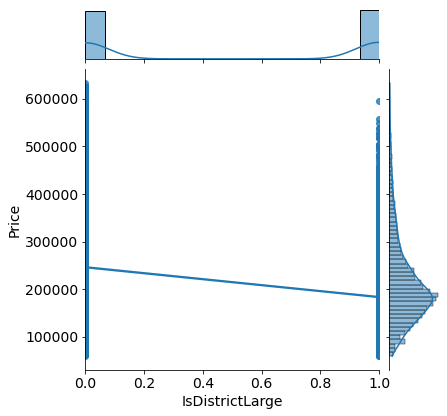

In [50]:
grid = sns.jointplot(train_df['IsDistrictLarge'], train_df['Price'], kind='reg')
grid.fig.set_figwidth(6)
grid.fig.set_figheight(6)

plt.show()

In [51]:
district_size = test_df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()


,DistrictId,DistrictSize
0,27,391
1,1,344
2,23,264
3,6,257
4,9,132


In [52]:
test_df = test_df.merge(district_size, on='DistrictId', how='left')
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,HouseFloor_outlier,DistrictSize
0,4567,44,1.0,36.847630,19.094183,5.0,5,9.0,1970,0.036122,...,1,24,4378,0,1036.0,1,1,1,0,46
1,5925,62,1.0,42.493908,42.568134,10.0,7,17.0,2017,0.072158,...,1,2,629,1,900.0,0,0,0,0,122
2,960,27,2.0,59.463676,38.973679,9.0,19,19.0,1977,0.211401,...,1,9,1892,0,900.0,0,1,1,0,391
3,3848,23,3.0,49.646030,33.893826,6.0,2,2.0,1965,0.014073,...,1,2,475,0,900.0,0,0,1,0,264
4,746,74,1.0,53.837055,33.347054,9.0,8,17.0,1977,0.309479,...,1,35,7715,4,990.0,0,6,1,0,61


In [53]:
test_df['IsDistrictLarge'] = (test_df['DistrictSize'] > 100).astype(int)

MedPriceByDistrict

In [54]:
Med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrict'})

In [55]:
Med_price_by_district.shape

(668, 3)

In [56]:
train_df = train_df.merge(Med_price_by_district, on=['DistrictId', 'Rooms'], how='left')

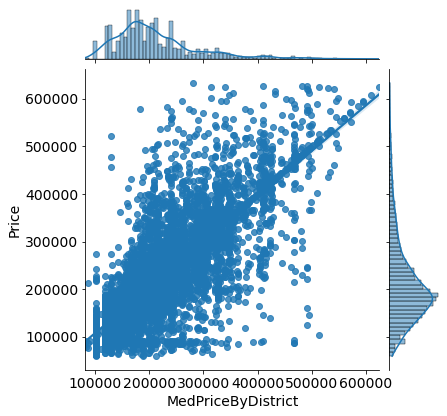

In [57]:
grid = sns.jointplot(train_df['MedPriceByDistrict'], train_df['Price'], kind='reg')
grid.fig.set_figwidth(6)
grid.fig.set_figheight(6)

plt.show()

In [58]:
test_df = test_df.merge(Med_price_by_district, on=['DistrictId', 'Rooms'], how='left')

In [59]:
test_df.loc[test_df['MedPriceByDistrict'].isna(), 'MedPriceByDistrict'] = train_df['MedPriceByDistrict'].median()

Med_price_by_KitchenSquare

In [60]:
Med_price_by_KitchenSquare = train_df.groupby(['KitchenSquare', 'Rooms'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'Med_price_by_KitchenSquare'})

In [61]:
Med_price_by_KitchenSquare.shape

(131, 3)

In [62]:
train_df = train_df.merge(Med_price_by_KitchenSquare, on=['KitchenSquare', 'Rooms'], how='left')

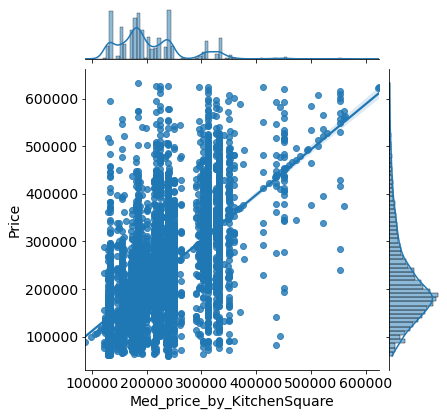

In [63]:
grid = sns.jointplot(train_df['Med_price_by_KitchenSquare'], train_df['Price'], kind='reg')
grid.fig.set_figwidth(6)
grid.fig.set_figheight(6)

plt.show()

In [64]:
test_df = test_df.merge(Med_price_by_KitchenSquare, on=['KitchenSquare', 'Rooms'], how='left')

In [65]:
test_df.loc[test_df['Med_price_by_KitchenSquare'].isna(), 'Med_price_by_KitchenSquare'] = train_df['Med_price_by_KitchenSquare'].median()

Год постройки

In [66]:
med_price_by_HouseYear = train_df.groupby(['HouseYear', 'Rooms'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'med_price_by_HouseYear'})
med_price_by_HouseYear.head()                                            

,HouseYear,Rooms,med_price_by_HouseYear
0,1910,1.0,287954.71875
1,1912,1.0,262279.81250
2,1912,4.0,284884.96875
3,1914,2.0,423580.46875
4,1916,3.0,284608.93750


In [67]:
med_price_by_HouseYear.shape

(325, 3)

In [68]:
train_df = train_df.merge(med_price_by_HouseYear, on=['HouseYear', 'Rooms'], how='left')

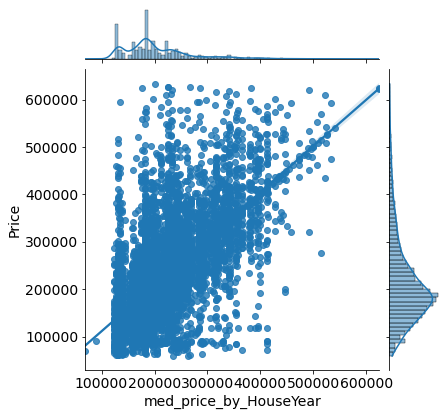

In [69]:
grid = sns.jointplot(train_df['med_price_by_HouseYear'], train_df['Price'], kind='reg')
grid.fig.set_figwidth(6)
grid.fig.set_figheight(6)

plt.show()

In [70]:
test_df = test_df.merge(med_price_by_HouseYear, on=['HouseYear', 'Rooms'], how='left')

In [71]:
test_df.loc[test_df['med_price_by_HouseYear'].isna(), 'med_price_by_HouseYear'] = train_df['med_price_by_HouseYear'].median()

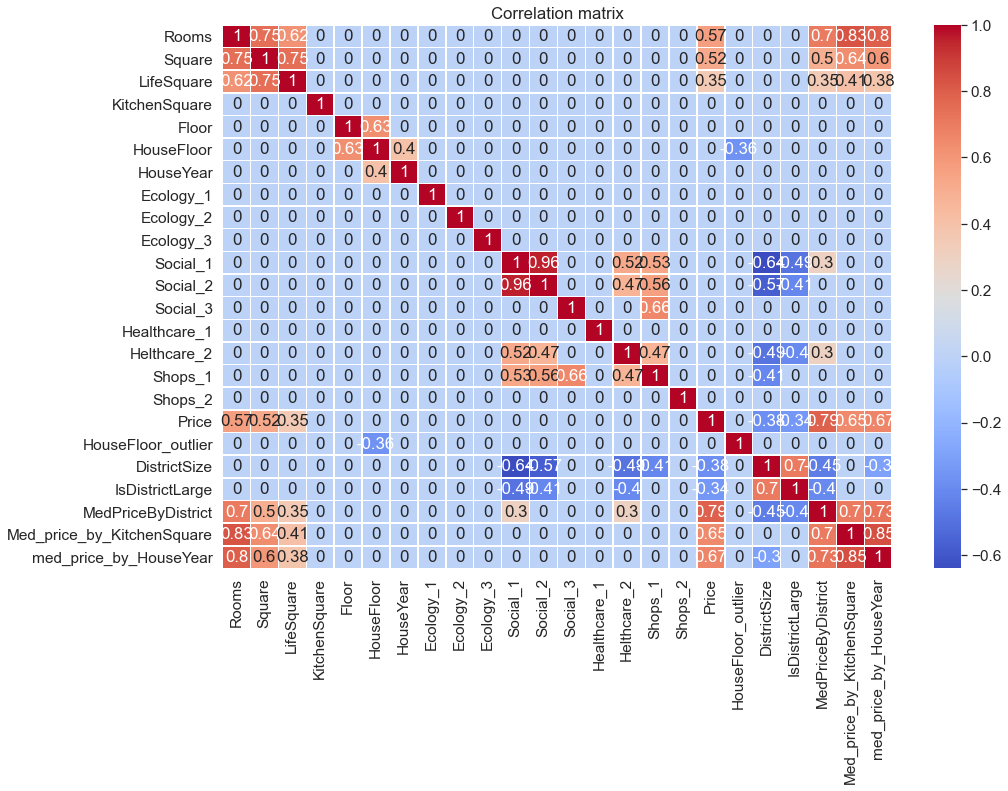

In [72]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = train_df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

In [73]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Id                          5000 non-null   object 
 1   DistrictId                  5000 non-null   object 
 2   Rooms                       5000 non-null   float32
 3   Square                      5000 non-null   float32
 4   LifeSquare                  5000 non-null   float32
 5   KitchenSquare               5000 non-null   float32
 6   Floor                       5000 non-null   int64  
 7   HouseFloor                  5000 non-null   float32
 8   HouseYear                   5000 non-null   int16  
 9   Ecology_1                   5000 non-null   float32
 10  Ecology_2                   5000 non-null   int64  
 11  Ecology_3                   5000 non-null   int64  
 12  Social_1                    5000 non-null   int8   
 13  Social_2                    5000 

class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.kitchen_square_quantile = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        
        self.medians = X.median()
    
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        
        x.loc[x['Rooms'].isin([]), 'Rooms'] = self.medians['Rooms']
        
        # Square, LifeSquare, KitchenSquare
        
        condition = (x['Square'] > x['Square'].quantile(.975)) | (x['Square'] < x['Square'].quantile(.025))
           x.loc[condition, 'Square'] = x['Square'].median()

        condition = (x['LifeSquare'] > x['LifeSquare'].quantile(.975)) | (x['LifeSquare'] < x['LifeSquare'].quantile(.025))
           x.loc[condition, 'LifeSquare'] = x['LifeSquare'].median()
        x.loc[x['LifeSquare'] < 10, 'LifeSquare'] = 10
            condition = (x['KitchenSquare'].isna()) \
                 | (x['KitchenSquare'] > x['KitchenSquare'].quantile(.975))
        x.loc[condition, 'KitchenSquare'] = x['KitchenSquare'].median()

        x.loc[x['KitchenSquare'] < 3, 'KitchenSquare'] = np.random.randint(3, 12)
     
        
        # HouseFloor, Floor 
        
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor']\
                                            .apply(lambda x: random.randint(1, x))
        
        # HouseYear
        current_year = datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
            
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) & \
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 11.49
        
        
        X.fillna(self.medians, inplace=True)
        
        return X

class FeatureGenetator():
    """Генерация новых признвков"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.house_year_min = None
        self.district_size = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # Target encoding
        ## District, Rooms
        df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
            ## year
        if y is not None:
            self.house_year_max = df['HouseYear'].max()
            self.house_year_min = df['HouseYear'].min()
            df['Price'] = y.values
            df = self.year_to_cat(df)
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
            
            
        


Отбор признаков

In [74]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'HouseFloor_outlier',
 'DistrictSize',
 'IsDistrictLarge',
 'MedPriceByDistrict',
 'Med_price_by_KitchenSquare',
 'med_price_by_HouseYear']

In [75]:
feature_names = ['Rooms', 'Square','LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3',
 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2','HouseFloor_outlier', 'DistrictSize', 'IsDistrictLarge', 'MedPriceByDistrict',               
 'med_price_by_HouseYear', 'Med_price_by_KitchenSquare']                  

target_name = 'Price'

Разбиение на train и test

In [76]:
X = train_df[feature_names]
y = train_df[target_name]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

Обучение

In [77]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=10,
                                     min_samples_leaf=900,
                                     random_state=42,  
                                     n_estimators=1000)
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(criterion='mse', max_depth=10, min_samples_leaf=900,
                          n_estimators=1000, random_state=42)

Train R2:	0.787
Test R2:	0.718


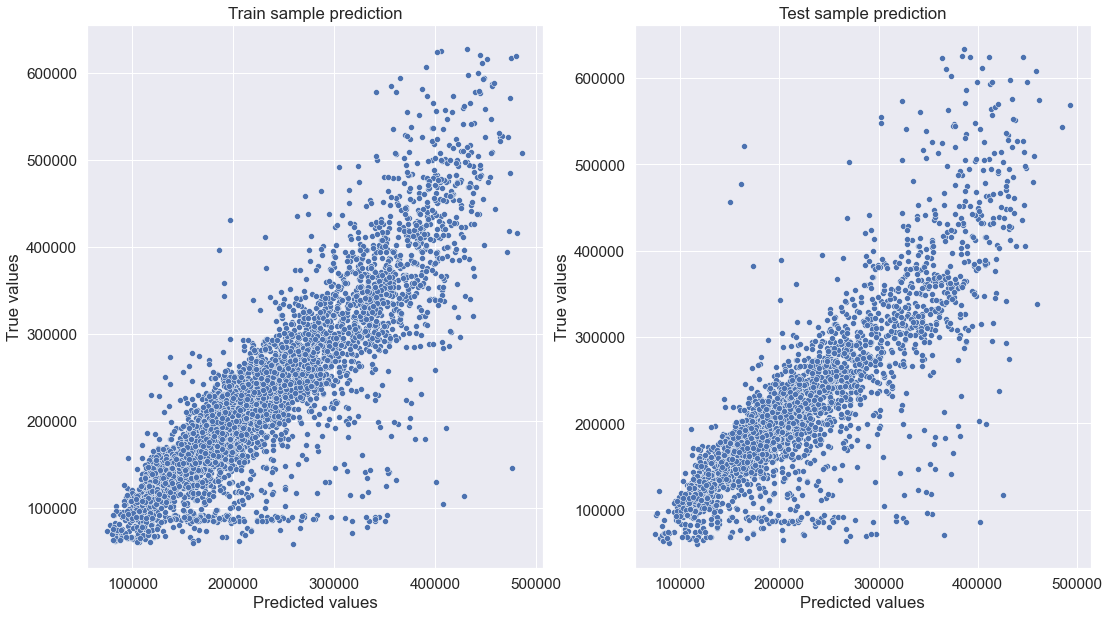

In [78]:
y_train_preds = gb_model.predict(X_train)
y_valid_preds = gb_model.predict(X_valid)
evaluate_preds(y_train, y_train_preds, y_valid, y_valid_preds)


In [79]:
cv_score = cross_val_score(gb_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.68597168, 0.70116935, 0.7088287 ])

In [80]:
cv_score.mean()

0.6986565771765075

Прогноз

In [81]:
test_id = test_df['Id']

In [82]:
pred_df = pd.DataFrame()

In [83]:
pred_df['Id'] = test_id

In [84]:
pred_df.head

<bound method NDFrame.head of          Id
0      4567
1      5925
2       960
3      3848
4       746
...     ...
4995  10379
4996  16138
4997   3912
4998   5722
4999  11004

[5000 rows x 1 columns]>

In [85]:
pred_df['Price'] = gb_model.predict(test_df[feature_names])

In [86]:
assert pred_df.shape[0] == 5000, f'Real pred-shape = {pred_df.shape[0]}, Expected pred-shape = 5000'

pred_df.to_csv('./archive/predictions_.csv', index = False)

In [87]:
pred_df = pd.read_csv('./archive/predictions_.csv')
pred_df.head

<bound method NDFrame.head of          Id          Price
0      4567  152065.439604
1      5925  133075.940355
2       960  143153.765808
3      3848  128752.212025
4       746  210252.118461
...     ...            ...
4995  10379  176262.259330
4996  16138  404255.238227
4997   3912  139187.240560
4998   5722  191755.990957
4999  11004  291868.976888

[5000 rows x 2 columns]>

In [88]:
test_df.shape

(5000, 25)